# Hot Delivery - Part II
Team 3

## Importing Packages

In [ ]:
!pip install Pulp

In [ ]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pulp
import datetime


# Initialize seaborn (for plotting)
sns.set()

## Loading and Inspecting Data


In [ ]:
#Case 1: orders A

dfOrdersA= pd.read_csv("part2_ordersA.csv",index_col=0)
dfOrdersA

,customer,estimated availability
restaurant,,
Scarborough (Kennedy Park / Ionview / East Birchmount Park),Scarborough (Woburn),2022-04-02 7:27 PM
Central Toronto (North Toronto West),Etobicoke (Westmount),2022-04-02 8:30 PM


In [ ]:
#Case 2: orders B

dfOrdersB= pd.read_csv("part2_ordersB.csv",index_col=0)
dfOrdersB

,customer,estimated availability
restaurant,,
Etobicoke (Islington Avenue),Downtown Toronto Stn A PO Boxes 25 The Esplana...,2022-04-02 5:17 PM
North York (Sweeney Park / Wigmore Park),Downtown Toronto (University of Toronto / Harb...,2022-04-02 5:49 PM
Scarborough (The Golden Mile / Clairlea / Oakridge / Birchmount Park East),Downtown Toronto (Rosedale),2022-04-02 6:17 PM
Etobicoke (Westmount),Etobicoke (West Deane Park / Princess Gardens ...,2022-04-02 5:53 PM


In [ ]:
# Average Distance between neighborhoods

dfDistance = pd.read_csv("distances.csv")
dfDistance

,origin,destination,distance
0,Scarborough (Malvern / Rouge River),Scarborough (Rouge Hill / Port Union / Highlan...,3.931478
1,Scarborough (Malvern / Rouge River),Scarborough (Guildwood / Morningside / Ellesmere),4.864191
2,Scarborough (Malvern / Rouge River),Scarborough (Woburn),4.778347
3,Scarborough (Malvern / Rouge River),Scarborough (Cedarbrae),6.009861
4,Scarborough (Malvern / Rouge River),Scarborough (Eglinton),7.876162
...,...,...,...
10297,Etobicoke (South Steeles / Silverstone / Humbe...,Etobicoke (Westmount),6.971037
10298,Etobicoke Northwest (Clairville / Humberwood /...,Etobicoke (Westmount),5.185601
10299,Etobicoke (South Steeles / Silverstone / Humbe...,Etobicoke (Kingsview Village / St. Phillips / ...,6.390667
10300,Etobicoke Northwest (Clairville / Humberwood /...,Etobicoke (Kingsview Village / St. Phillips / ...,3.793723


In [ ]:
#regional data

dfRegions = pd.read_csv("regions.csv")
dfRegions

,name,province,code,latitude,longitude
0,Scarborough (Malvern / Rouge River),Ontario,M1B,43.8113,-79.1930
1,Scarborough (Rouge Hill / Port Union / Highlan...,Ontario,M1C,43.7878,-79.1564
2,Scarborough (Guildwood / Morningside / Ellesmere),Ontario,M1E,43.7678,-79.1866
3,Scarborough (Woburn),Ontario,M1G,43.7712,-79.2144
4,Scarborough (Cedarbrae),Ontario,M1H,43.7686,-79.2389
...,...,...,...,...,...
97,Weston,Ontario,M9N,43.7068,-79.5170
98,Etobicoke (Westmount),Ontario,M9P,43.6949,-79.5323
99,Etobicoke (Kingsview Village / St. Phillips / ...,Ontario,M9R,43.6898,-79.5582
100,Etobicoke (South Steeles / Silverstone / Humbe...,Ontario,M9V,43.7432,-79.5876


In [ ]:
#set travel mins dictionary
regions = list(dfRegions["name"].unique())

travelMinsDict = {}
for i in regions:
    for j in regions:
        if i == j:
            travelMinsDict[(i,j)] = float(0)
        else: 
            travelMinsDict[(i,j)] = (float(dfDistance[(dfDistance["origin"] == i)&(dfDistance["destination"] == j)]["distance"])/40) * 60


## Part II - Case 1 Solution

### Sets

In [ ]:
#fucntion to calculate time difference in minutes
def getTimeDifference(TimeStart, TimeEnd):
    TimeStart = datetime.datetime.strptime(TimeStart, '%Y-%m-%d %H:%M %p')
    TimeEnd = datetime.datetime.strptime(TimeEnd, '%Y-%m-%d %H:%M %p')
    timeDiff = TimeEnd - TimeStart
    return timeDiff.total_seconds() / 60

In [ ]:
#restaurants
restaurants= list(dfOrdersA.index)

#customers
customers=list(dfOrdersA['customer'])

#number of trips
numtrips=len((customers+restaurants))

#restaurant-customer list
rescustlist=['Downtown Toronto (Rosedale)']+restaurants+customers

#steps
steps = list(range(1, len(rescustlist)))

#starting points
startarc = list(range(len(rescustlist)))

#ending points
endarc = steps.copy()

#estimated availability for orders
order_availability = [getTimeDifference('2022-04-02 0:00 AM', item) for item in list(dfOrdersA['estimated availability'])]

In [ ]:
regions = list(dfRegions["name"].unique())

distancedictionary = {}
for i in regions:
    for j in regions:
        if i == j:
            distancedictionary[(i,j)] = float(0)
        else: 
            distancedictionary[(i,j)] = float(dfDistance[(dfDistance["origin"] == i)&(dfDistance["destination"] == j)]["distance"])


### Variables

In [ ]:
def createVariables():
    """create part 2 varaibles"""
    #variables: if travelling from resteurant i to customer j at step t
    xvar = pulp.LpVariable.dict("x", (startarc,endarc,steps), cat=pulp.LpBinary)

    #variable: total travel time at each step
    dvar = pulp.LpVariable.dict("d", (steps), cat=pulp.LpContinuous)

    #variable: wait time for each customer 
    wvar = pulp.LpVariable.dict("w", (endarc), cat=pulp.LpContinuous)
    
    return xvar, dvar, wvar

### Model Initialization

In [ ]:
#initialize model

def initializeModel():
    """initialize part 2 model"""
    flowModel = pulp.LpProblem(name="Part 2 Solution", sense=pulp.LpMinimize)
    return flowModel

### Constraints

In [ ]:
def createConstraints(flowModel):
    """create constraints for part 2 model"""
    #Constraint: every location must be visited once
    for j in endarc:
        flowModel+= pulp.lpSum( [xvar[i,j,t] for i in startarc for t in steps]) ==1

    #Constraint: conservation of flow (go to node j in step t then start at node j in step t+1) 
    for t in steps[:-1]:
        for j in endarc:
            flowModel += (pulp.lpSum([xvar[(i, j, t)]] for i in startarc) == pulp.lpSum([xvar[(j, k, t+1)]] for k in endarc))


    # during the first step downtown rosedale has an outflow of 1, others are zero
    flowModel += pulp.lpSum([xvar[(0, j, 1)] for j in endarc]) == 1
    for i in startarc:
        if i != 0:
            flowModel += pulp.lpSum([xvar[(i, j, 1)]  for j in endarc]) == 0

    #Constraint: precedence must occur (must pick up food before dropping off at customer)
    for t in steps:
        for j in endarc:
            if j > len(customers):
                if t == 1:
                    flowModel += pulp.lpSum(xvar[i, j, t] for i in startarc) == 0 
                else:
                    flowModel += pulp.lpSum(xvar[(i, j, t)] for i in startarc) <= pulp.lpSum(xvar[(i, j-len(customers), past_t)] for i in startarc for past_t in steps[:t-1])

    ## Constraints added for part 2
    #Constraint: the first step downtown rosedale to the first restaurant has timestamp equal to the restaurant's ready time.
    flowModel += dvar[1] == pulp.lpSum([order_availability[j-1] * xvar[(0,j,1)]] for j in endarc if j <= len(customers))

    #set time at each step based on the distance and the speed 40km/h
    for t in steps:
        if t != 1:
            for j in endarc:
                for i in endarc:
                    if i > len(customers):
                        #add 5 mins since leaving from customers
                        flowModel += dvar[t] >= (dvar[t-1] + pulp.lpSum([travelMinsDict[(rescustlist[i],rescustlist[j])] * xvar[(i, j, t)]]
                                                              + (5 * xvar[(i,j,t)]))) 
                    else:
                        #leave time must be greater than last timestamp + travel time
                        flowModel += dvar[t] >= dvar[t-1] + pulp.lpSum([travelMinsDict[(rescustlist[i],rescustlist[j])] * xvar[(i, j, t)]])

                        #leave time must be greater than order ready time + travel time
                        flowModel += dvar[t] >= pulp.lpSum(xvar[(i,j,t)] * order_availability[i-1]) + pulp.lpSum([travelMinsDict[(rescustlist[i],rescustlist[j])] * xvar[(i, j, t)]])

    #Constraint: average wating time < W (W=60minuets)
    u = 999999
    for j in endarc:
        if j > len(customers):
            for t in steps:
                for i in startarc:
                    flowModel += wvar[j] >= 0
                    flowModel += wvar[j] >= dvar[t] - order_availability[(j-len(customers)-1)] - u*(1 - xvar[(i, j, t)])
                    flowModel += wvar[j] <= dvar[t] - order_availability[(j-len(customers)-1)] + u*(1 - xvar[(i, j, t)])

    flowModel += pulp.lpSum([wvar[j] for j in range(len(customers) + 1, len(endarc) + 1)]) / len(customers) <= W




### Objective Function

In [ ]:
def addObjective():
    """add objetive for part2 model"""
    objective=0
    for i in startarc:
        for j in endarc:
            if i != j:
                objective += pulp.lpSum([distancedictionary[(rescustlist[i],rescustlist[j])] * xvar[(i, j, t)] for t in steps])
                
    return objective

### Run Model

In [ ]:
#set W
W = 60

xvar, dvar, wvar = createVariables() #create variables
flowModel = initializeModel() #initialize model
createConstraints(flowModel) #create constraints
objective = addObjective() #add objective

In [ ]:
# Solve model
flowModel+=objective
flowModel.solve()
print("Status:", pulp.LpStatus[flowModel.status])

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/shirley.zhang/opt/anaconda3/lib/python3.8/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/jj/335494hd5z5cblj975hs90400000gp/T/925ed59db3894392a9ff4882f569a23b-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/jj/335494hd5z5cblj975hs90400000gp/T/925ed59db3894392a9ff4882f569a23b-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 228 COLUMNS
At line 1232 RHS
At line 1456 BOUNDS
At line 1543 ENDATA
Problem MODEL has 223 rows, 86 columns and 779 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 12.795 - 0.00 seconds
Cgl0002I 18 variables fixed
Cgl0003I 34 fixed, 0 tightened bounds, 84 strengthened rows, 6 substitutions
Cgl0003I 4 fixed, 0 tightened bounds, 28 strengthened rows, 6 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 24 strengthened rows,

In [ ]:
# Print solution
print("Total distance:" + str(pulp.value(flowModel.objective))+'\n')

for t in steps:
    print(t)
    for i in startarc:
        for j in endarc:
            if xvar[i,j,t].varValue >= 1.0:
                if j <= len(customers):
                    print(f'Driving from {rescustlist[i]} To \n{rescustlist[j]} for pickup')
                else:
                    print(f'Driving from {rescustlist[i]} To \n{rescustlist[j]} for delivery') 
                    print(f'Customer wait time is {wvar[(j)].varValue} minutes')
    print()  

Total distance:43.315801485558396

1
Driving from Downtown Toronto (Rosedale) To 
Scarborough (Kennedy Park / Ionview / East Birchmount Park) for pickup

2
Driving from Scarborough (Kennedy Park / Ionview / East Birchmount Park) To 
Scarborough (Woburn) for delivery
Customer wait time is 9.1241854 minutes

3
Driving from Scarborough (Woburn) To 
Central Toronto (North Toronto West) for pickup

4
Driving from Central Toronto (North Toronto West) To 
Etobicoke (Westmount) for delivery
Customer wait time is 15.509793 minutes



### Plot W vs. Distance

In [ ]:
W_list = list(range(100, 0, -5))
distances = []

for W in W_list:
    xvar, dvar, wvar = createVariables() #create variables
    flowModel = initializeModel() #initialize model
    createConstraints(flowModel) #create constraints
    objective = addObjective() #add objective
    
    flowModel+=objective
    flowModel.solve()
    
    if pulp.LpStatus[flowModel.status] == 'Optimal':
        distances.append(pulp.value(flowModel.objective))
    else:
        distances.append(0)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/shirley.zhang/opt/anaconda3/lib/python3.8/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/jj/335494hd5z5cblj975hs90400000gp/T/2490ccb713854681b280990ac4557e64-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/jj/335494hd5z5cblj975hs90400000gp/T/2490ccb713854681b280990ac4557e64-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 228 COLUMNS
At line 1232 RHS
At line 1456 BOUNDS
At line 1543 ENDATA
Problem MODEL has 223 rows, 86 columns and 779 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 12.795 - 0.00 seconds
Cgl0002I 18 variables fixed
Cgl0003I 34 fixed, 0 tightened bounds, 84 strengthened rows, 6 substitutions
Cgl0003I 4 fixed, 0 tightened bounds, 28 strengthened rows, 6 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 24 strengthened rows,

/Users/shirley.zhang/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


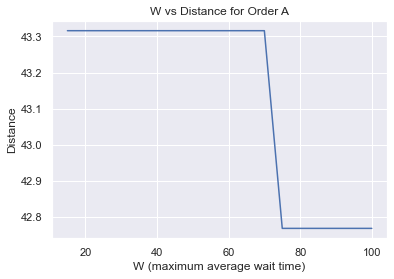

In [ ]:
ax = sns.lineplot(W_list[:-2], distances[:-2])
ax.set(xlabel='W (maximum average wait time)', ylabel='Distance')
plt.title("W vs Distance for Order A")
plt.show()

## Part II - Case 2 Solution

### Sets

In [ ]:
#resteurants
restaurants= list(dfOrdersB.index)

#customers
customers=list(dfOrdersB['customer'])

#number of trips
numtrips=len((customers+restaurants))

#resteurant-customer list
rescustlist=['Downtown Toronto (Rosedale)']+restaurants+customers

#steps
steps = list(range(1, len(rescustlist)))

#starting points
startarc = list(range(len(rescustlist)))

#ending points
endarc = steps.copy()

#estimated availability for orders
order_availability = [getTimeDifference('2022-04-02 0:00 AM', item) for item in list(dfOrdersB['estimated availability'])]

In [ ]:
#set W
W = 60

xvar, dvar, wvar = createVariables() #create variables
flowModel = initializeModel() #initialize model
createConstraints(flowModel) #create constraints
objective = addObjective() #add objective

# Solve model
flowModel+=objective
flowModel.solve()
print("Status:", pulp.LpStatus[flowModel.status])


/Users/shirley.zhang/opt/anaconda3/lib/python3.8/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/shirley.zhang/opt/anaconda3/lib/python3.8/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/jj/335494hd5z5cblj975hs90400000gp/T/933c45728bce41449a8fce479421d5e6-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/jj/335494hd5z5cblj975hs90400000gp/T/933c45728bce41449a8fce479421d5e6-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1648 COLUMNS
At line 9990 RHS
At line 11634 BOUNDS
At line 12223 ENDATA
Problem MODEL has 1643 rows, 588 columns and 6685 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 13.4694 - 0.01 seconds
Cgl0002I 68 variables fixed
Cgl0003I 68 fixed, 3 tightened bounds, 692 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 381 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 457 strength

In [ ]:
# Print solution
print("Total distance:" + str(pulp.value(flowModel.objective))+'\n')

for t in steps:
    print(t)
    for i in startarc:
        for j in endarc:
            if xvar[i,j,t].varValue >= 1.0:
                if j <= len(customers):
                    print(f'Driving from {rescustlist[i]} To \n{rescustlist[j]} for pickup')
                else:
                    print(f'Driving from {rescustlist[i]} To \n{rescustlist[j]} for delivery') 
                    print(f'Customer wait time is {wvar[(j)].varValue} minutes')
    print()  

Total distance:55.628504305056005

1
Driving from Downtown Toronto (Rosedale) To 
Etobicoke (Westmount) for pickup

2
Driving from Etobicoke (Westmount) To 
Etobicoke (West Deane Park / Princess Gardens / Martin Grove / Islington / Cloverdale) for delivery
Customer wait time is 7.7666201 minutes

3
Driving from Etobicoke (West Deane Park / Princess Gardens / Martin Grove / Islington / Cloverdale) To 
Etobicoke (Islington Avenue) for pickup

4
Driving from Etobicoke (Islington Avenue) To 
North York (Sweeney Park / Wigmore Park) for pickup

5
Driving from North York (Sweeney Park / Wigmore Park) To 
Scarborough (The Golden Mile / Clairlea / Oakridge / Birchmount Park East) for pickup

6
Driving from Scarborough (The Golden Mile / Clairlea / Oakridge / Birchmount Park East) To 
Downtown Toronto (Rosedale) for delivery
Customer wait time is 36.582509 minutes

7
Driving from Downtown Toronto (Rosedale) To 
Downtown Toronto (University of Toronto / Harbord) for delivery
Customer wait time i

In [ ]:
W_list = list(range(100, 0, -5))
distances = []

for W in W_list:
    xvar, dvar, wvar = createVariables() #create variables
    flowModel = initializeModel() #initialize model
    createConstraints(flowModel) #create constraints
    objective = addObjective() #add objective
    
    flowModel+=objective
    flowModel.solve()
    
    if pulp.LpStatus[flowModel.status] == 'Optimal':
        distances.append(pulp.value(flowModel.objective))
    else:
        distances.append(0)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/shirley.zhang/opt/anaconda3/lib/python3.8/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/jj/335494hd5z5cblj975hs90400000gp/T/38249bc4409844f99a488bf34d51a417-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/jj/335494hd5z5cblj975hs90400000gp/T/38249bc4409844f99a488bf34d51a417-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1648 COLUMNS
At line 9990 RHS
At line 11634 BOUNDS
At line 12223 ENDATA
Problem MODEL has 1643 rows, 588 columns and 6685 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 13.4694 - 0.00 seconds
Cgl0002I 68 variables fixed
Cgl0003I 68 fixed, 3 tightened bounds, 692 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 381 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 457 strength

/Users/shirley.zhang/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


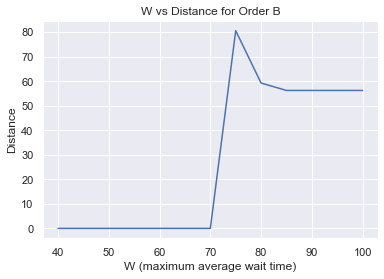

In [ ]:
ax = sns.lineplot(W_list[:-7], distances[:-7])
ax.set(xlabel='W (maximum average wait time)', ylabel='Distance')
plt.title("W vs Distance for Order B")
plt.show()

## Change constraint average wait time to max wait time

In [ ]:
#update create constraints function
def createConstraints(flowModel):
    """create constraints for part 2 model with constraint on max wait time"""
    #Constraint: every location must be visited once
    for j in endarc:
        flowModel+= pulp.lpSum( [xvar[i,j,t] for i in startarc for t in steps]) ==1

    #Constraint: conservation of flow (go to node j in step t then start at node j in step t+1) 
    for t in steps[:-1]:
        for j in endarc:
            flowModel += (pulp.lpSum([xvar[(i, j, t)]] for i in startarc) == pulp.lpSum([xvar[(j, k, t+1)]] for k in endarc))


    # during the first step downtown rosedale has an outflow of 1, others are zero
    flowModel += pulp.lpSum([xvar[(0, j, 1)] for j in endarc]) == 1
    for i in startarc:
        if i != 0:
            flowModel += pulp.lpSum([xvar[(i, j, 1)]  for j in endarc]) == 0

    #Constraint: precedence must occur (must pick up food before dropping off at customer)
    for t in steps:
        for j in endarc:
            if j > len(customers):
                if t == 1:
                    flowModel += pulp.lpSum(xvar[i, j, t] for i in startarc) == 0 
                else:
                    flowModel += pulp.lpSum(xvar[(i, j, t)] for i in startarc) <= pulp.lpSum(xvar[(i, j-len(customers), past_t)] for i in startarc for past_t in steps[:t-1])

    ## Constraints added for part 2
    #Constraint: the first step downtown rosedale to the first restaurant has timestamp equal to the restaurant's ready time.
    flowModel += dvar[1] == pulp.lpSum([order_availability[j-1] * xvar[(0,j,1)]] for j in endarc if j <= len(customers))

    #set time at each step based on the distance and the speed 40km/h
    for t in steps:
        if t != 1:
            for j in endarc:
                for i in endarc:
                    if i > len(customers):
                        #add 5 mins since leaving from customers
                        flowModel += dvar[t] >= (dvar[t-1] + pulp.lpSum([travelMinsDict[(rescustlist[i],rescustlist[j])] * xvar[(i, j, t)]]
                                                              + (5 * xvar[(i,j,t)]))) 
                    else:
                        #leave time must be greater than last timestamp + travel time
                        flowModel += dvar[t] >= dvar[t-1] + pulp.lpSum([travelMinsDict[(rescustlist[i],rescustlist[j])] * xvar[(i, j, t)]])

                        #leave time must be greater than order ready time + travel time
                        flowModel += dvar[t] >= pulp.lpSum(xvar[(i,j,t)] * order_availability[i-1]) + pulp.lpSum([travelMinsDict[(rescustlist[i],rescustlist[j])] * xvar[(i, j, t)]])

    #Constraint: maximum wating time < W (W=60minuets)
    u = 999999
    for j in endarc:
        if j > len(customers):
            for t in steps:
                for i in startarc:
                    flowModel += wvar[j] >= 0
                    flowModel += wvar[j] <= W
                    flowModel += wvar[j] >= dvar[t] - order_availability[(j-len(customers)-1)] - u*(1 - xvar[(i, j, t)])
                    flowModel += wvar[j] <= dvar[t] - order_availability[(j-len(customers)-1)] + u*(1 - xvar[(i, j, t)])
    


### Case 1 with new constraint

In [ ]:
#restaurants
restaurants= list(dfOrdersA.index)

#customers
customers=list(dfOrdersA['customer'])

#number of trips
numtrips=len((customers+restaurants))

#restaurant-customer list
rescustlist=['Downtown Toronto (Rosedale)']+restaurants+customers

#steps
steps = list(range(1, len(rescustlist)))

#starting points
startarc = list(range(len(rescustlist)))

#ending points
endarc = steps.copy()

#estimated availability for orders
order_availability = [getTimeDifference('2022-04-02 0:00 AM', item) for item in list(dfOrdersA['estimated availability'])]

In [ ]:
W_list = list(range(100, 0, -5))
distances = []

for W in W_list:
    xvar, dvar, wvar = createVariables() #create variables
    flowModel = initializeModel() #initialize model
    createConstraints(flowModel) #create constraints
    objective = addObjective() #add objective
    
    flowModel+=objective
    flowModel.solve()
    
    if pulp.LpStatus[flowModel.status] == 'Optimal':
        distances.append(pulp.value(flowModel.objective))
    else:
        distances.append(0)

/Users/shirley.zhang/opt/anaconda3/lib/python3.8/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/shirley.zhang/opt/anaconda3/lib/python3.8/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/jj/335494hd5z5cblj975hs90400000gp/T/aa4df01b97d44ae1b5786b63d6d3ca09-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/jj/335494hd5z5cblj975hs90400000gp/T/aa4df01b97d44ae1b5786b63d6d3ca09-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 267 COLUMNS
At line 1309 RHS
At line 1572 BOUNDS
At line 1659 ENDATA
Problem MODEL has 262 rows, 86 columns and 817 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 12.795 - 0.00 seconds
Cgl0002I 18 variables fixed
Cgl0003I 34 fixed, 0 tightened bounds, 84 strengthened rows, 6 substitutions
Cgl0003I 4 fixed, 0 tightened bounds, 29 strengthened rows, 6 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 24 strengthened rows,

/Users/shirley.zhang/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


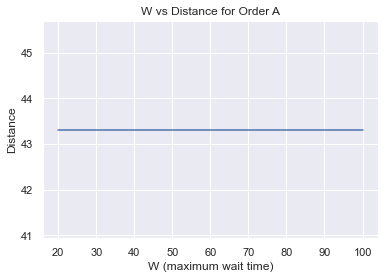

In [ ]:
ax = sns.lineplot(W_list[:-3], distances[:-3])
ax.set(xlabel='W (maximum wait time)', ylabel='Distance')
plt.title("W vs Distance for Order A")
plt.show()

### Case 2 with new constraint

In [ ]:
#restaurants
restaurants= list(dfOrdersB.index)

#customers
customers=list(dfOrdersB['customer'])

#number of trips
numtrips=len((customers+restaurants))

#restaurant-customer list
rescustlist=['Downtown Toronto (Rosedale)']+restaurants+customers

#steps
steps = list(range(1, len(rescustlist)))

#starting points
startarc = list(range(len(rescustlist)))

#ending points
endarc = steps.copy()

#estimated availability for orders
order_availability = [getTimeDifference('2022-04-02 0:00 AM', item) for item in list(dfOrdersB['estimated availability'])]

In [ ]:
W_list = list(range(100, 0, -5))
distances = []

for W in W_list:
    xvar, dvar, wvar = createVariables() #create variables
    flowModel = initializeModel() #initialize model
    createConstraints(flowModel) #create constraints
    objective = addObjective() #add objective
    
    flowModel+=objective
    flowModel.solve()
    
    if pulp.LpStatus[flowModel.status] == 'Optimal':
        distances.append(pulp.value(flowModel.objective))
    else:
        distances.append(0)

/Users/shirley.zhang/opt/anaconda3/lib/python3.8/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/shirley.zhang/opt/anaconda3/lib/python3.8/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/jj/335494hd5z5cblj975hs90400000gp/T/050e90d82cf54942880e768767b0850f-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/jj/335494hd5z5cblj975hs90400000gp/T/050e90d82cf54942880e768767b0850f-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1935 COLUMNS
At line 10561 RHS
At line 12492 BOUNDS
At line 13081 ENDATA
Problem MODEL has 1930 rows, 588 columns and 6969 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 13.4694 - 0.01 seconds
Cgl0002I 68 variables fixed
Cgl0003I 68 fixed, 3 tightened bounds, 692 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 381 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 457 strengt

/Users/shirley.zhang/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


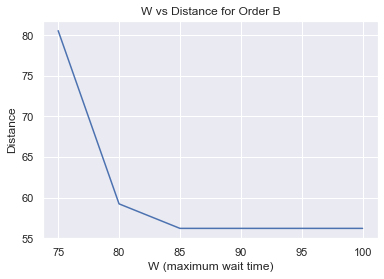

In [ ]:
ax = sns.lineplot(W_list[:-14], distances[:-14])
ax.set(xlabel='W (maximum wait time)', ylabel='Distance')
plt.title("W vs Distance for Order B")
plt.show()